In [ ]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


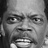

In [ ]:
# loading a sample image
sample_image = Image.open("/content/gdrive/MyDrive/Expression Dataset/Train_Relabeled_Cleaned/angry/10.jpg")
sample_image

In [ ]:
np.array(sample_image).shape

(48, 48)

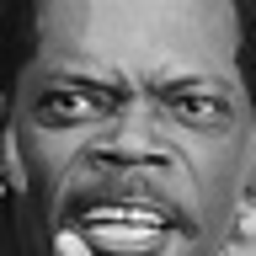

In [ ]:
sample_image = sample_image.resize([256,256])
sample_image

In [ ]:
np.array(sample_image).shape

(256, 256)

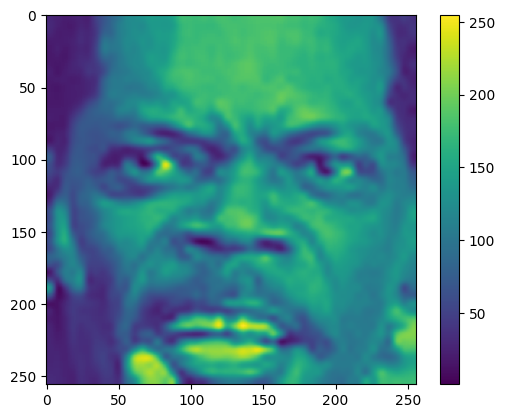

In [ ]:
plt.imshow(np.array(sample_image))
plt.colorbar()

## Extract only face from images

In [ ]:
from google.colab.patches import cv2_imshow

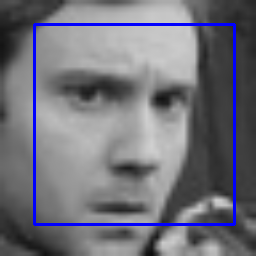

In [ ]:
import cv2

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Read the input image
img = cv2.imread('/content/gdrive/MyDrive/images/train/angry/0.jpg')
img = cv2.resize(img, dsize=(256,256))
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cropped_img= img[x:x+w, y:y+h]
    cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
    # Display the output
cv2_imshow(img)

In [ ]:
cropped_img.shape

(256, 256, 3)

In [ ]:
cropped_img = cropped_img.sum(axis=2)

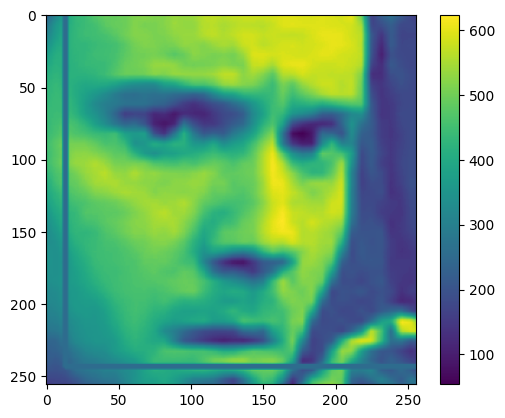

In [ ]:
plt.imshow(cropped_img)
plt.colorbar()

## Load Data and Extract only Face

In [ ]:
import cv2

In [ ]:
def load_extract_normalize(image_path, normalized=True):
    # Read the input image and resize
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(256,256))
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # crop faces
    for (x, y, w, h) in faces:
        cropped_img= img[x:x+w, y:y+h].astype('float32')
        cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
        cropped_img = cropped_img.sum(axis=2)

    if normalized:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32) / 255.0
        else:
          return np.array(img).astype(np.float32) / 255.0
    else:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32)
        else:
          return np.array(img).astype(np.float32)

In [ ]:
def load_normalize(image_path, normalized=True):
    image = Image.open(image_path).resize([128,128])
    image = np.array(image).astype(np.float32)
    if len(image.shape) == 3:
        image = image.sum(axis=2)
    if normalized:
        return image / 255.0
    else:
        return image

In [ ]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/images/train
emo_types = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

# # Load the cascade
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/MyDrive/Expression Dataset/Train_Relabeled_Cleaned/', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

In [ ]:
print(f"There are {len(x_data)} in total.")

There are 27546 in total.


In [ ]:
for i,emo in enumerate(emo_types):
  print(emo,":", y_data.count(i))

angry : 3977
disgust : 551
fear : 3867
happy : 7230
neutral : 4580
sad : 4696
surprise : 2645


(22036, 128, 128, 1) (22036, 7)
(5510, 128, 128, 1) (5510, 7)


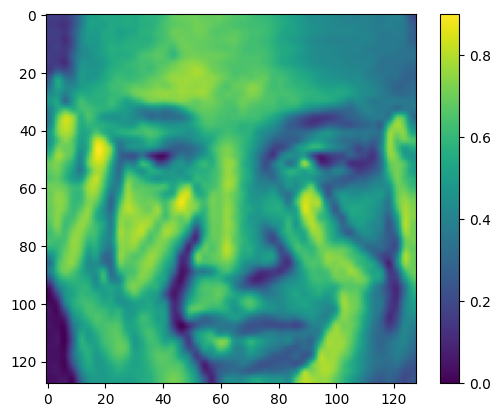

In [ ]:
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 128, 128, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

## Base VGG16

In [ ]:
VGG16_model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(x_train[0].shape),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # dense layer:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),

    # output layer:
    tf.keras.layers.Dense(7, activation='softmax')
])

In [ ]:
VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                    

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                     loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                     metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [ ]:
n_epoch = 30
hist = VGG16_model.fit(x_train, y_train,
              epochs=n_epoch,
              batch_size=32,
              validation_data=(x_val, y_val),
              callbacks=[callback])

Epoch 1/30
689/689 [==============================] - 109s 129ms/step - loss: 1.8166 - categorical_accuracy: 0.2602 - val_loss: 1.7977 - val_categorical_accuracy: 0.2710
Epoch 2/30
689/689 [==============================] - 87s 126ms/step - loss: 1.7023 - categorical_accuracy: 0.3178 - val_loss: 1.5100 - val_categorical_accuracy: 0.4062
Epoch 3/30
689/689 [==============================] - 87s 126ms/step - loss: 1.4198 - categorical_accuracy: 0.4484 - val_loss: 1.3994 - val_categorical_accuracy: 0.4583
Epoch 4/30
689/689 [==============================] - 87s 126ms/step - loss: 1.2241 - categorical_accuracy: 0.5304 - val_loss: 1.2185 - val_categorical_accuracy: 0.5368
Epoch 5/30
689/689 [==============================] - 87s 127ms/step - loss: 1.0714 - categorical_accuracy: 0.5957 - val_loss: 1.1640 - val_categorical_accuracy: 0.5670
Epoch 6/30
689/689 [==============================] - 87s 127ms/step - loss: 0.9094 - categorical_accuracy: 0.6628 - val_loss: 1.1509 - val_categorical_ac

In [ ]:
# VGG16_model.save('/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/VGG16_model')

In [ ]:
n_epoch = 9

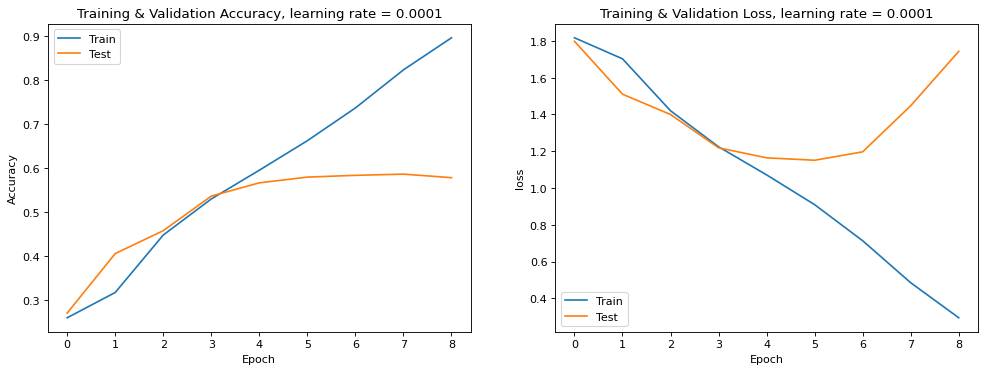

In [ ]:
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(np.arange(n_epoch),hist.history.get('categorical_accuracy'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_categorical_accuracy'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.title("Training & Validation Accuracy, learning rate = 0.0001")

plt.subplot(1, 2, 2) # index 2
plt.plot(np.arange(n_epoch),hist.history.get('loss'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_loss'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title("Training & Validation Loss, learning rate = 0.0001")
plt.show()

In [ ]:
# Save the weights
VGG16_model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/VGG16_modelVGG16_model')

### Test Model

In [ ]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/images/train
x_test = []
y_test = []

# # Load the cascade
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/MyDrive/Expression Dataset/Validation_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

(6488, 128, 128, 1) (6488,)


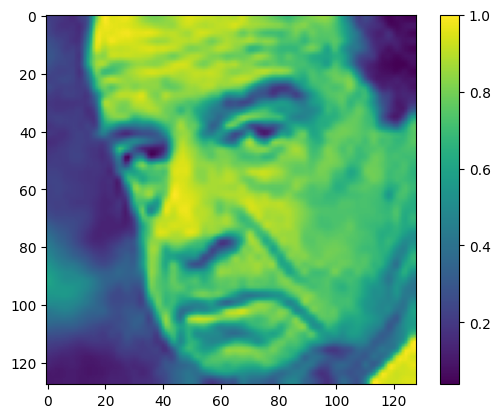

In [ ]:
# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 128, 128, 1)
y_test = np.array(y_test)

# folder = StratifiedKFold(5, shuffle=True)
# x_indices = np.arange(0, len(x_data))
# train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# # shuffling
# np.random.shuffle(train_indices)

# x_train = x_data[train_indices]
# y_train = np.eye(len(emo_types))[y_data[train_indices]]
y_test = np.eye(len(emo_types))[y_test]

# x_val = x_data[val_indices]
# y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_test.shape, y_test.shape)

plt.imshow(x_test[0,:,:,0])
plt.colorbar()

In [ ]:
y_test = np.eye(len(emo_types))[y_test]

In [ ]:
# Evaluate the model
loss, acc = VGG16_model.evaluate(x_test, y_test, verbose=2)
print("VGG 16 model, accuracy: {:5.2f}%".format(100 * acc))

203/203 - 8s - loss: 1.7595 - categorical_accuracy: 0.5754 - 8s/epoch - 39ms/step
VGG 16 model, accuracy: 57.54%


In [ ]:
y_pred = VGG16_model.predict(x_test, verbose=2)

203/203 - 7s - 7s/epoch - 34ms/step


In [ ]:
y_pred = np.argmax(y_pred,axis = 1)

In [ ]:
y_pred

array([4, 0, 0, ..., 3, 3, 6])

In [ ]:
y_test = np.argmax(y_test,axis = 1)

In [ ]:
y_test

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.50      0.42      0.46       888
           1       0.46      0.42      0.44        83
           2       0.41      0.41      0.41       916
           3       0.77      0.82      0.79      1752
           4       0.51      0.58      0.54      1181
           5       0.46      0.42      0.44      1088
           6       0.66      0.65      0.66       580

    accuracy                           0.58      6488
   macro avg       0.54      0.53      0.53      6488
weighted avg       0.57      0.58      0.57      6488



Seems overfitted. Next step is try to reduce overfitting.

## Batch Normalisation and Drop Out

In [ ]:
VGG16_model_bn = tf.keras.models.Sequential([
    
    # Input layer
    tf.keras.layers.Input(x_train[0].shape),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # dense layer:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    # Batch Normalisation layer:
    tf.keras.layers.BatchNormalization(),


    # output layer:
    tf.keras.layers.Dense(7, activation='softmax')
])

In [ ]:
VGG16_model_bn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                     loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                     metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [ ]:
n_epoch = 30
hist = VGG16_model_bn.fit(x_train, y_train,
              epochs=n_epoch,
              batch_size=32,
              validation_data=(x_val, y_val),
              callbacks=[callback])

Epoch 1/30
689/689 [==============================] - 112s 152ms/step - loss: 1.9995 - categorical_accuracy: 0.2967 - val_loss: 1.7099 - val_categorical_accuracy: 0.3365
Epoch 2/30
689/689 [==============================] - 104s 151ms/step - loss: 1.5659 - categorical_accuracy: 0.4227 - val_loss: 1.2998 - val_categorical_accuracy: 0.4895
Epoch 3/30
689/689 [==============================] - 104s 151ms/step - loss: 1.2972 - categorical_accuracy: 0.5136 - val_loss: 1.2421 - val_categorical_accuracy: 0.5307
Epoch 4/30
689/689 [==============================] - 104s 151ms/step - loss: 1.1496 - categorical_accuracy: 0.5704 - val_loss: 1.2021 - val_categorical_accuracy: 0.5528
Epoch 5/30
689/689 [==============================] - 104s 151ms/step - loss: 1.0357 - categorical_accuracy: 0.6187 - val_loss: 1.1594 - val_categorical_accuracy: 0.5721
Epoch 6/30
689/689 [==============================] - 104s 151ms/step - loss: 0.9321 - categorical_accuracy: 0.6566 - val_loss: 1.1199 - val_categoric

In [ ]:
n_epoch=11

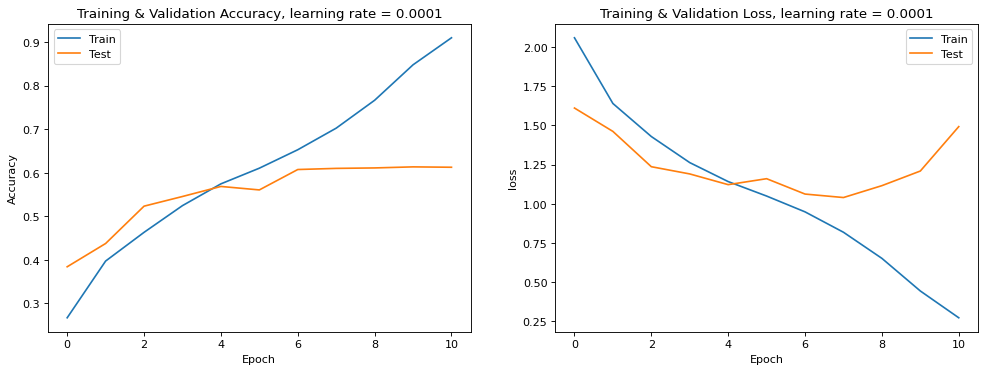

In [ ]:
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(np.arange(n_epoch),hist.history.get('categorical_accuracy'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_categorical_accuracy'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.title("Training & Validation Accuracy, learning rate = 0.0001")

plt.subplot(1, 2, 2) # index 2
plt.plot(np.arange(n_epoch),hist.history.get('loss'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_loss'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title("Training & Validation Loss, learning rate = 0.0001")
plt.show()

In [ ]:
# VGG16_model_bn.save('/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/VGG16_model_bn')

In [ ]:
# Save the weights
VGG16_model_bn.save_weights('/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/VGG16_model_bn')

In [ ]:
y_test = np.eye(len(emo_types))[y_test]

In [ ]:
# Evaluate the model
loss, acc = VGG16_model_bn.evaluate(x_test, y_test, verbose=2)
print("VGG 16 model, accuracy: {:5.2f}%".format(100 * acc))

203/203 - 8s - loss: 1.4099 - categorical_accuracy: 0.5825 - 8s/epoch - 40ms/step
VGG 16 model, accuracy: 58.25%


In [ ]:
y_pred = VGG16_model_bn.predict(x_test, verbose=2)

203/203 - 8s - 8s/epoch - 39ms/step


In [ ]:
y_pred = np.argmax(y_pred,axis = 1)

In [ ]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
y_test = np.argmax(y_test,axis = 1)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.47      0.56      0.51       888
           1       0.62      0.22      0.32        83
           2       0.37      0.42      0.39       916
           3       0.85      0.80      0.82      1752
           4       0.58      0.52      0.55      1181
           5       0.45      0.44      0.45      1088
           6       0.68      0.67      0.68       580

    accuracy                           0.58      6488
   macro avg       0.57      0.52      0.53      6488
weighted avg       0.59      0.58      0.59      6488

